# Work Plan for Churn Forecasting for Interconnect Telecom:

1. Data Understanding and Preparation:

Read and load the data from the four CSV files (contract.csv, personal.csv, internet.csv, and phone.csv) into pandas DataFrames.

Check the structure of the data, identify missing values, and handle any necessary data cleaning and preprocessing.
Merge the DataFrames based on the customerID column to create a comprehensive dataset for analysis.

2. Exploratory Data Analysis (EDA):

Perform EDA to gain insights into the data, understand the distribution of variables, and identify patterns and trends.

Explore the distribution of churned clients and analyze the impact of various services and contract types on churn rates.
Investigate relationships between different features (e.g., monthly charges, tenure, internet services) and churn.

3. Feature Engineering:

Create new relevant features that may help in improving the churn prediction model.

Encode categorical variables and convert them into numerical representations for modeling.

4. Model Selection:

Choose appropriate machine learning models for churn prediction. Common models include Logistic Regression, Random Forest, Gradient Boosting, Support Vector Machines, etc.

Divide the data into training and testing sets for model evaluation.

5. Model Training and Evaluation:

Train the selected models on the training data.

Evaluate the models using appropriate metrics such as accuracy AUC-ROC.

6. Identify the best-performing model based on evaluation results.

Use the best-performing model to forecast churn for new clients based on their data.

Identify potential churned clients in real-time and apply appropriate strategies for retention (e.g., promotional codes, special plan options).

7. Reporting and Visualization:

Create a conclusion summarizing the findings and insights from the analysis.


In [1]:
!pip install xgboost
!pip install --upgrade scikit-learn



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from catboost import CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
df_contract = pd.read_csv(r'C:/Users/kevin/datasets/contract.csv') # contract information
df_personal = pd.read_csv(r'C:/Users/kevin/datasets/personal.csv') # clients personal data
df_internet = pd.read_csv(r'C:/Users/kevin/datasets/internet.csv') # information about internet services
df_phone = pd.read_csv(r'C:/Users/kevin/datasets/phone.csv') # information about telephone services

# General Information & Data Preprocessing 

In [4]:
df_contract.info()
#change data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_contract.sample(15)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
1417,5651-WYIPH,2018-08-01,No,Month-to-month,Yes,Credit card (automatic),49.85,865.75
3260,4183-WCSEP,2017-04-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,78.45,2435.15
6512,1353-LJWEM,2019-03-01,No,Month-to-month,Yes,Electronic check,60.90,688.5
325,4983-CLMLV,2015-10-01,No,Month-to-month,Yes,Credit card (automatic),102.70,5138.1
271,7633-MVPUY,2015-05-01,No,Two year,Yes,Electronic check,59.75,3450.15
5997,3462-BJQQA,2019-08-01,No,Month-to-month,Yes,Electronic check,89.75,552.65
3905,5759-RCVCB,2019-10-01,2020-01-01 00:00:00,Month-to-month,No,Credit card (automatic),35.20,108.95
6023,4698-KVLLG,2015-11-01,No,Two year,No,Credit card (automatic),19.60,967.9
5580,8859-YSTWS,2016-02-01,No,One year,No,Bank transfer (automatic),19.95,1004.5
4056,3329-WDIOK,2019-10-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,50.60,155.35


In [6]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

In [7]:
df_contract.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

In [8]:
df_contract.duplicated().sum()

0

In [9]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(df_contract['TotalCharges'].median())

In [10]:
df_contract.rename(columns={'Type':'Billing Cycle', 'customerID':'Customer ID', 'BeginDate':'Start Date',
                           'EndDate':'End Date','PaperlessBilling':'Paperless Billing','PaymentMethod':'Payment Method',
                           'MonthlyCharges':'Monthly Charges','TotalCharges':'Total Charges'}, inplace=True)

In [11]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
df_personal.sample(15)

,customerID,gender,SeniorCitizen,Partner,Dependents
1142,2460-NGXBJ,Male,1,Yes,Yes
3370,5307-UVGNB,Female,0,Yes,Yes
1785,1568-LJSZU,Male,0,Yes,Yes
4618,6350-XFYGW,Male,1,No,No
4716,5176-OLSKT,Female,0,Yes,No
4260,5269-NRGDP,Male,0,Yes,Yes
1917,3219-JQRSL,Female,1,Yes,No
3114,0867-LDTTC,Male,0,No,No
6660,1447-GIQMR,Male,0,Yes,No
49,2954-PIBKO,Female,0,Yes,Yes


In [13]:
df_personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [14]:
df_personal.duplicated().sum()

0

In [15]:
df_personal.rename(columns={'customerID' : 'Customer ID', 'gender': 'Gender', 'SeniorCitizen':'Senior Citizen'}, inplace=True)

In [16]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [17]:
df_internet.sample(15)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1659,0925-VYDLG,Fiber optic,No,No,No,No,No,No
2656,0744-GKNGE,Fiber optic,Yes,No,No,Yes,No,No
1690,8894-JVDCV,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
4024,5840-NVDCG,DSL,Yes,Yes,No,Yes,No,Yes
3212,6624-JDRDS,DSL,Yes,No,No,No,No,No
136,1875-QIVME,Fiber optic,No,No,Yes,Yes,Yes,Yes
495,4765-OXPPD,DSL,Yes,Yes,Yes,Yes,No,No
4690,5685-IIXLY,Fiber optic,No,Yes,No,No,No,Yes
3673,6595-COKXZ,DSL,No,No,No,No,No,No
1644,2955-BJZHG,Fiber optic,No,No,No,No,Yes,No


In [18]:
df_internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [19]:
df_internet.duplicated().sum()

0

In [20]:
df_internet.rename(columns={'customerID' : 'Customer ID', 'InternetService':'Internet Service','OnlineBackup':'Online Backup',
                           'DeviceProtection':'Device Protection','TechSupport':'Tech Support',
                           'StreamingTV':'Streaming TV','StreamingMovies':'Streaming Movies',
                            'OnlineSecurity':'Online Security'}, inplace=True)

In [21]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
df_phone.sample(15)

,customerID,MultipleLines
1568,6407-UTSLV,No
1528,0793-TWELN,Yes
5490,9445-SZLCH,Yes
2029,5494-WOZRZ,No
454,1135-LMECX,No
84,7233-PAHHL,Yes
446,4513-CXYIX,Yes
1848,1488-PBLJN,Yes
1501,7426-WEIJX,Yes
4094,3530-VWVGU,No


In [23]:
df_phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [24]:
df_phone.duplicated().sum()

0

In [25]:
df_phone.rename(columns={'customerID' : 'Customer ID', 'MultipleLines':'Multiple Lines'}, inplace=True)

In [26]:
df_merge = df_contract.merge(df_personal, on='Customer ID', how='left')
df_merged2 = df_merge.merge(df_phone,on='Customer ID',how='left')
df_telecom = df_merged2.merge(df_internet, on='Customer ID', how='left')

In [27]:
df_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Customer ID        7043 non-null   object        
 1   Start Date         7043 non-null   datetime64[ns]
 2   End Date           7043 non-null   object        
 3   Billing Cycle      7043 non-null   object        
 4   Paperless Billing  7043 non-null   object        
 5   Payment Method     7043 non-null   object        
 6   Monthly Charges    7043 non-null   float64       
 7   Total Charges      7043 non-null   float64       
 8   Gender             7043 non-null   object        
 9   Senior Citizen     7043 non-null   int64         
 10  Partner            7043 non-null   object        
 11  Dependents         7043 non-null   object        
 12  Multiple Lines     6361 non-null   object        
 13  Internet Service   5517 non-null   object        
 14  Online S

In [28]:
df_telecom.isna().sum()

Customer ID             0
Start Date              0
End Date                0
Billing Cycle           0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Multiple Lines        682
Internet Service     1526
Online Security      1526
Online Backup        1526
Device Protection    1526
Tech Support         1526
Streaming TV         1526
Streaming Movies     1526
dtype: int64

In [29]:
def fill_nan_with_default(df, columns):
    default_value = 'Did Not Purchase'
    for col in columns:
        df[col] = df[col].fillna(default_value)
    return df

columns_to_fill = ['Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup',
                   'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']

df_telecom = fill_nan_with_default(df_telecom, columns_to_fill)


In [30]:
df_telecom.sample(25)

,Customer ID,Start Date,End Date,Billing Cycle,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Gender,Senior Citizen,Partner,Dependents,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies
6818,2710-WYVXG,2019-11-01,No,Two year,No,Mailed check,71.10,213.35,Female,0,No,No,No,DSL,Yes,Yes,No,Yes,No,Yes
1079,0455-XFASS,2019-11-01,No,Month-to-month,Yes,Electronic check,69.55,200.20,Female,0,Yes,Yes,No,Fiber optic,No,No,No,No,No,No
331,9498-FIMXL,2019-06-01,No,One year,Yes,Mailed check,19.20,161.95,Female,0,No,No,No,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase
3776,6968-URWQU,2016-07-01,No,One year,Yes,Mailed check,56.35,2391.15,Male,0,Yes,No,No,DSL,No,No,No,No,Yes,No
1419,3498-LZGQZ,2014-11-01,No,Two year,Yes,Mailed check,19.15,1177.05,Male,0,Yes,Yes,No,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase,Did Not Purchase
2465,1740-CSDJP,2019-12-01,2020-01-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),35.25,35.25,Male,0,No,No,Did Not Purchase,DSL,No,No,No,No,No,Yes
4056,3329-WDIOK,2019-10-01,2020-01-01 00:00:00,Month-to-month,Yes,Electronic check,50.60,155.35,Female,0,No,No,Did Not Purchase,DSL,No,Yes,No,No,Yes,Yes
4895,1394-SUIUH,2016-06-01,No,Month-to-month,Yes,Electronic check,85.15,3670.50,Female,1,Yes,No,No,Fiber optic,Yes,Yes,No,Yes,No,No
4879,4501-UYKBC,2016-04-01,No,One year,Yes,Credit card (automatic),69.10,3255.35,Female,1,No,No,Yes,DSL,No,No,Yes,Yes,No,Yes
6745,5515-AKOAJ,2015-06-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,100.10,5440.90,Female,0,No,No,Yes,Fiber optic,No,No,No,Yes,Yes,Yes


In [31]:
df_telecom.describe()

,Monthly Charges,Total Charges,Senior Citizen
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2281.916928,0.162147
std,30.090047,2265.270398,0.368612
min,18.250000,18.800000,0.000000
25%,35.500000,402.225000,0.000000
50%,70.350000,1397.475000,0.000000
75%,89.850000,3786.600000,0.000000
max,118.750000,8684.800000,1.000000


# Exploratory Data Analysis

In [32]:
## In our data, how many customers canceled their Interconnect subscription?

print((df_telecom['End Date'] == 'No').value_counts())

not_canceled = (df_telecom['End Date'] == 'No').sum()
canceled = (~ (df_telecom['End Date'] == 'No')).sum()
print()
print('% of customers that canceled their Interconnect subscription:', (canceled / not_canceled) * 100)


True     5174
False    1869
Name: End Date, dtype: int64

% of customers that canceled their Interconnect subscription: 36.122922303826826


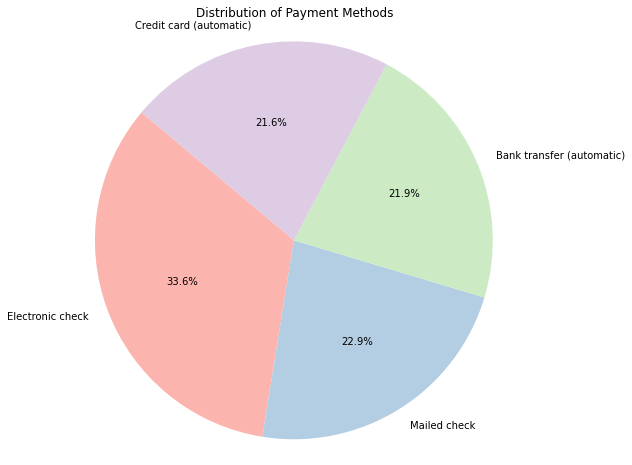

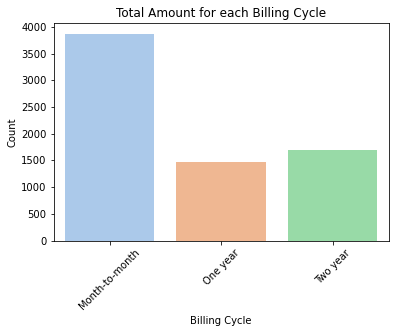

In [33]:
payment_counts = df_telecom['Payment Method'].value_counts().reset_index()
payment_counts.columns = ['Payment Method', 'Count']

payment_counts = payment_counts.sort_values(by='Count', ascending=False)


custom_colors = sns.color_palette('Pastel1')


plt.figure(figsize=(8, 8))
plt.pie(payment_counts['Count'], labels=payment_counts['Payment Method'], autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Distribution of Payment Methods')
plt.axis('equal')  
plt.show()

sns.countplot(x='Billing Cycle', data=df_telecom,palette='pastel')
plt.title('Total Amount for each Billing Cycle')
plt.xlabel('Billing Cycle')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [34]:
# Which gender is paying the most for Telecom? 
# Are individuals with a Significant Other paying more?
Gender_charges = df_telecom.groupby(['Gender'])['Total Charges'].sum()
print(Gender_charges)
print()
print()



Partner_charges = df_telecom.groupby('Senior Citizen')['Total Charges'].sum() 
print(Partner_charges)
print()
print()

Gender
Female    7959341.575
Male      8112199.350
Name: Total Charges, dtype: float64


Senior Citizen
0    1.286199e+07
1    3.209551e+06
Name: Total Charges, dtype: float64




In [35]:
df_telecom['End Date'] = pd.to_datetime(df_telecom['End Date'], errors='coerce')  # Coerce invalid dates to NaT

# Calculate the tenure for each individual
df_telecom['Tenure'] = (df_telecom['End Date'] - df_telecom['Start Date']).dt.days

# Filter out the rows where the 'End Date' is not equal to 'No' (indicating they canceled)
canceled_individuals = df_telecom[df_telecom['End Date'] != 'No']

# Calculate the average tenure of the canceled individuals
average_tenure_canceled = canceled_individuals['Tenure'].mean()

print("Average tenure of individuals who canceled Teleconnect:", average_tenure_canceled, "days")
print()
print(df_telecom['Tenure'].describe())

Average tenure of individuals who canceled Teleconnect: 547.3520599250936 days

count    1869.000000
mean      547.352060
std       594.389607
min        30.000000
25%        61.000000
50%       304.000000
75%       883.000000
max      2191.000000
Name: Tenure, dtype: float64


In [36]:
df_telecom['End Date'] = df_telecom['End Date'].fillna(0)
df_telecom['Tenure'] = df_telecom['Tenure'].fillna(0)
df_telecom['Tenure'] = df_telecom['Tenure'].astype('int')

In [37]:
canceled_users = df_telecom[df_telecom['End Date'] != 0]

users_canceled_df = canceled_users[
    ['Customer ID', 'Start Date', 'End Date','Tenure', 'Billing Cycle', 
     'Multiple Lines','Internet Service','Device Protection','Online Security','Tech Support',
    'Online Backup', 'Streaming TV','Streaming Movies','Payment Method']
]


users_canceled_df 


,Customer ID,Start Date,End Date,Tenure,Billing Cycle,Multiple Lines,Internet Service,Device Protection,Online Security,Tech Support,Online Backup,Streaming TV,Streaming Movies,Payment Method
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,61,Month-to-month,No,DSL,No,Yes,No,Yes,No,No,Mailed check
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,61,Month-to-month,No,Fiber optic,No,No,No,No,No,No,Electronic check
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,245,Month-to-month,Yes,Fiber optic,Yes,No,No,No,Yes,Yes,Electronic check
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,853,Month-to-month,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Electronic check
13,0280-XJGEX,2015-09-01,2019-10-01 00:00:00,1491,Month-to-month,Yes,Fiber optic,Yes,No,No,Yes,Yes,Yes,Bank transfer (automatic)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7021,1699-HPSBG,2018-11-01,2019-11-01 00:00:00,365,One year,No,DSL,No,No,Yes,No,Yes,No,Electronic check
7026,8775-CEBBJ,2019-02-01,2019-11-01 00:00:00,273,Month-to-month,No,DSL,No,No,No,No,No,No,Bank transfer (automatic)
7032,6894-LFHLY,2019-10-01,2019-11-01 00:00:00,31,Month-to-month,Yes,Fiber optic,No,No,No,No,No,No,Electronic check
7034,0639-TSIQW,2014-03-01,2019-10-01 00:00:00,2040,Month-to-month,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,No,Credit card (automatic)


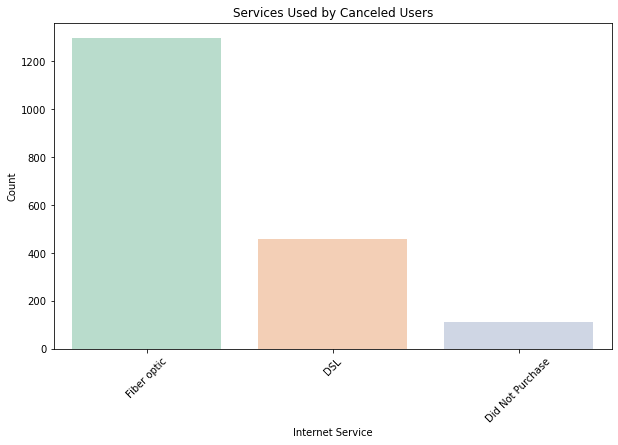

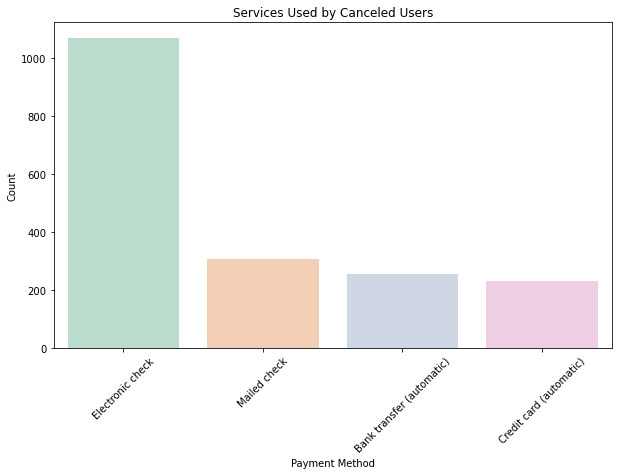

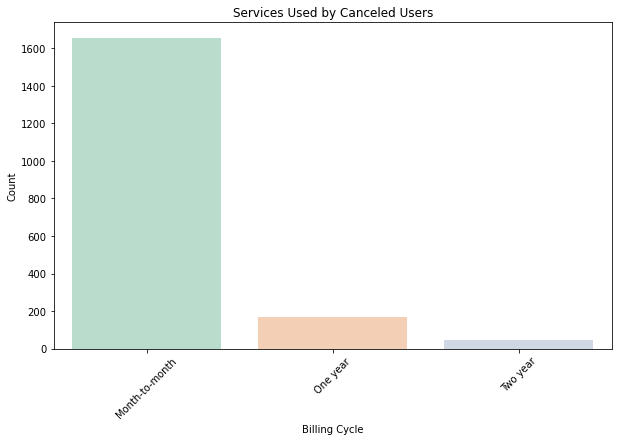

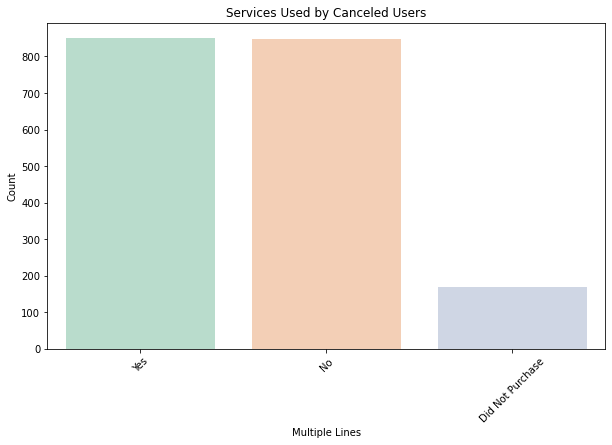

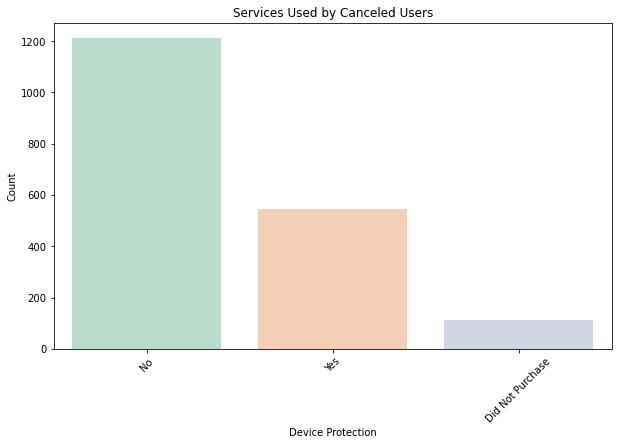

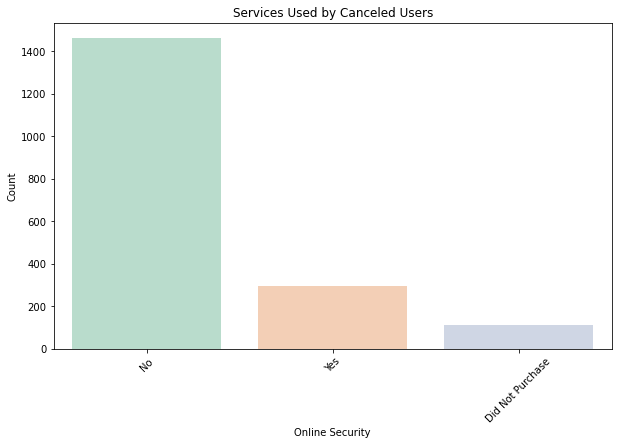

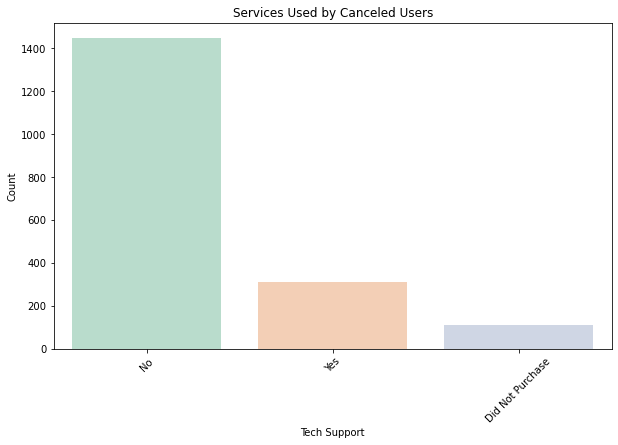

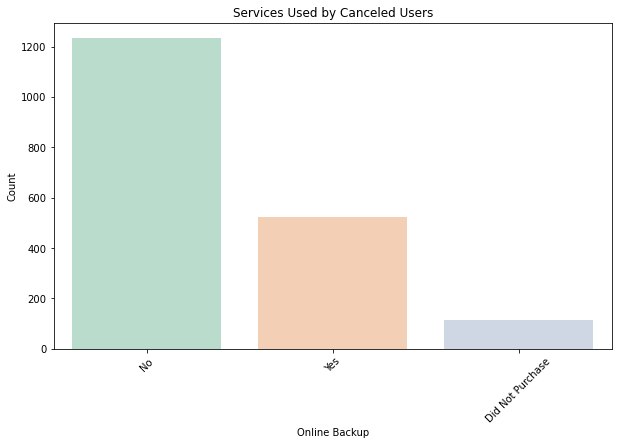

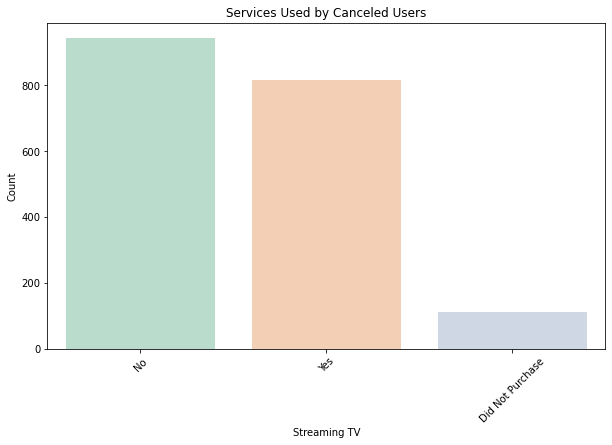

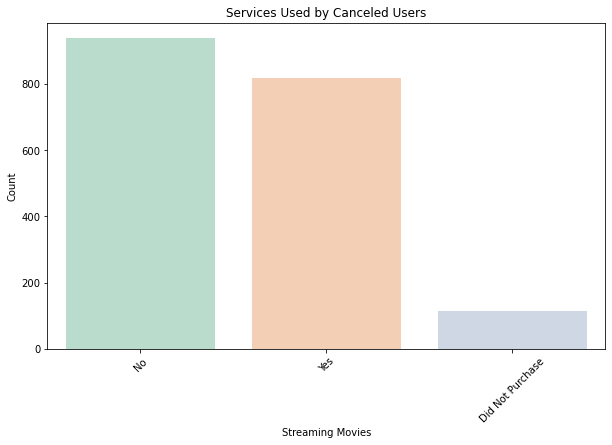

In [38]:
def plot_canceled_user_services(df, internet_service_column):
    
    service_counts = users_canceled_df[internet_service_column].value_counts().reset_index()
    service_counts.columns = [internet_service_column, 'Count']

    # Plot the stacked bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=internet_service_column, y='Count', data=service_counts, palette='Pastel2')
    plt.xlabel(internet_service_column)
    plt.ylabel('Count')
    plt.title('Services Used by Canceled Users')
    plt.xticks(rotation=45)
    plt.show()

plot_canceled_user_services(users_canceled_df, 'Internet Service')
plot_canceled_user_services(users_canceled_df, 'Payment Method')
plot_canceled_user_services(users_canceled_df, 'Billing Cycle')
plot_canceled_user_services(users_canceled_df, 'Multiple Lines')
plot_canceled_user_services(users_canceled_df, 'Device Protection')
plot_canceled_user_services(users_canceled_df, 'Online Security')
plot_canceled_user_services(users_canceled_df, 'Tech Support')
plot_canceled_user_services(users_canceled_df, 'Online Backup')
plot_canceled_user_services(users_canceled_df, 'Streaming TV')
plot_canceled_user_services(users_canceled_df, 'Streaming Movies')


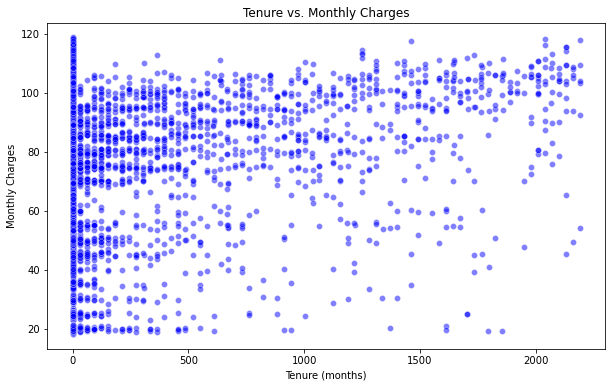

Correlation Coefficient: 0.252804382188075


In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Tenure', y='Monthly Charges', data=df_telecom, alpha=0.5, color='b')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges')
plt.title('Tenure vs. Monthly Charges')
plt.show()

correlation_coefficient = df_telecom['Tenure'].corr(df_telecom['Monthly Charges'])
print(f"Correlation Coefficient: {correlation_coefficient}")


In [40]:
def update_churn_status(date_value):
    if date_value == 0:
        return 'No Churn'
    else:
        return 'Churn'

df_telecom['End Date'] = df_telecom['End Date'].apply(update_churn_status)

In [41]:
df_telecom

,Customer ID,Start Date,End Date,Billing Cycle,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Gender,Senior Citizen,...,Dependents,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Tenure
0,7590-VHVEG,2020-01-01,No Churn,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,No,Did Not Purchase,DSL,No,Yes,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No Churn,One year,No,Mailed check,56.95,1889.50,Male,0,...,No,No,DSL,Yes,No,Yes,No,No,No,0
2,3668-QPYBK,2019-10-01,Churn,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,No,No,DSL,Yes,Yes,No,No,No,No,61
3,7795-CFOCW,2016-05-01,No Churn,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,No,Did Not Purchase,DSL,Yes,No,Yes,Yes,No,No,0
4,9237-HQITU,2019-09-01,Churn,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,No,No,Fiber optic,No,No,No,No,No,No,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No Churn,One year,Yes,Mailed check,84.80,1990.50,Male,0,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,No Churn,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,No Churn,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,Yes,Did Not Purchase,DSL,Yes,No,No,No,No,No,0
7041,8361-LTMKD,2019-07-01,Churn,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,...,No,Yes,Fiber optic,No,No,No,No,No,No,123


In [44]:
selected_columns_onehot = ['Paperless Billing', 'Billing Cycle', 'Payment Method', 'Gender','Multiple Lines',
                    'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
                    'Streaming Movies', 'Partner','Dependents','Senior Citizen']


data_onehot = df_telecom[selected_columns_onehot].copy()


onehot_encoder = OneHotEncoder()


data_onehot_encoded = onehot_encoder.fit_transform(df_telecom[selected_columns_onehot])


column_names = []
for i, column in enumerate(selected_columns_onehot):
    categories = onehot_encoder.categories_[i]
    column_names.extend([f"{column}_{category}" for category in categories])


data_onehot_encoded_df = pd.DataFrame(data_onehot_encoded.toarray(), columns=column_names)


df_telecom_encoded = df_telecom.drop(columns=selected_columns_onehot)

df_telecom_encoded = pd.concat([df_telecom_encoded, data_onehot_encoded_df], axis=1)

selected_columns_label = ['End Date']

data_label = df_telecom[selected_columns_label].copy()


label_encoder = LabelEncoder()

data_label_encoded = label_encoder.fit_transform(data_label.values.ravel())


df_telecom_encoded['End Date'] = data_label_encoded

In [45]:
df_telecom_encoded

,Customer ID,Start Date,End Date,Monthly Charges,Total Charges,Tenure,Paperless Billing_No,Paperless Billing_Yes,Billing Cycle_Month-to-month,Billing Cycle_One year,...,Streaming TV_Yes,Streaming Movies_Did Not Purchase,Streaming Movies_No,Streaming Movies_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Senior Citizen_0,Senior Citizen_1
0,7590-VHVEG,2020-01-01,1,29.85,29.85,0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,5575-GNVDE,2017-04-01,1,56.95,1889.50,0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3668-QPYBK,2019-10-01,0,53.85,108.15,61,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,7795-CFOCW,2016-05-01,1,42.30,1840.75,0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,9237-HQITU,2019-09-01,0,70.70,151.65,61,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,1,84.80,1990.50,0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7039,2234-XADUH,2014-02-01,1,103.20,7362.90,0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7040,4801-JZAZL,2019-03-01,1,29.60,346.45,0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
7041,8361-LTMKD,2019-07-01,0,74.40,306.60,123,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


# Final Project Solution Code

Here are some of the criteria used by the project reviewers:

Have you performed all the steps?

Does the solution match the task condition?

Have you trained and tested the model correctly?

What is the quality score of the best model?

Have you kept to the project structure?

Have you kept the code neat?

In [46]:
features_encoded = df_telecom_encoded.drop(['Start Date', 'Customer ID', 'End Date','Tenure'], axis=1)
target_encoded = df_telecom_encoded['End Date']

In [47]:
features_encoded

,Monthly Charges,Total Charges,Paperless Billing_No,Paperless Billing_Yes,Billing Cycle_Month-to-month,Billing Cycle_One year,Billing Cycle_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,...,Streaming TV_Yes,Streaming Movies_Did Not Purchase,Streaming Movies_No,Streaming Movies_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Senior Citizen_0,Senior Citizen_1
0,29.85,29.85,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,56.95,1889.50,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,53.85,108.15,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,42.30,1840.75,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,70.70,151.65,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,84.80,1990.50,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7039,103.20,7362.90,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7040,29.60,346.45,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
7041,74.40,306.60,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


In [48]:
features_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 43 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Monthly Charges                           7043 non-null   float64
 1   Total Charges                             7043 non-null   float64
 2   Paperless Billing_No                      7043 non-null   float64
 3   Paperless Billing_Yes                     7043 non-null   float64
 4   Billing Cycle_Month-to-month              7043 non-null   float64
 5   Billing Cycle_One year                    7043 non-null   float64
 6   Billing Cycle_Two year                    7043 non-null   float64
 7   Payment Method_Bank transfer (automatic)  7043 non-null   float64
 8   Payment Method_Credit card (automatic)    7043 non-null   float64
 9   Payment Method_Electronic check           7043 non-null   float64
 10  Payment Method_Mailed check         

In [49]:
target_encoded

0       1
1       1
2       0
3       1
4       0
       ..
7038    1
7039    1
7040    1
7041    0
7042    1
Name: End Date, Length: 7043, dtype: int32

In [50]:
df_telecom['End Date']

0       No Churn
1       No Churn
2          Churn
3       No Churn
4          Churn
          ...   
7038    No Churn
7039    No Churn
7040    No Churn
7041       Churn
7042    No Churn
Name: End Date, Length: 7043, dtype: object

<AxesSubplot:ylabel='End Date'>

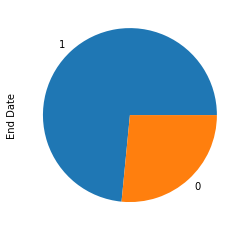

In [51]:
target_encoded.value_counts().plot(kind='pie')

# 1 = No Churn

# 0 = Churn

In [52]:
features_train, features_test, target_train, target_test = train_test_split(features_encoded, target_encoded, test_size=0.4, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=.5, random_state=12345)

In [53]:
print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)

(2112, 43)
(2112,)
(2113, 43)
(2113,)


In [54]:
scaler = StandardScaler()
numeric = ['Monthly Charges', 'Total Charges']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train[numeric])
print(features_valid[numeric])
print(features_test[numeric])

      Monthly Charges  Total Charges
3129         1.023949       1.920261
2108        -0.630331      -0.037668
2583         0.192677       0.772219
5027         0.711603      -0.619284
1609         1.570969       1.530552
...               ...            ...
2662        -0.488205      -0.955497
890          0.835550       0.251164
3367         0.833897       1.058975
5922         1.362738       2.364857
1643         0.870255       0.514473

[2112 rows x 2 columns]
      Monthly Charges  Total Charges
5755         1.073528      -0.380614
4289        -1.451687      -0.518738
3739        -1.302951      -0.733695
2581        -1.454993      -0.907652
3692         0.169541      -0.891623
...               ...            ...
5558         1.731274       2.777065
4572         1.392485       1.835634
6378         0.662024      -0.511739
4459         1.197475      -0.951125
3977         1.523043       1.965654

[2113 rows x 2 columns]
      Monthly Charges  Total Charges
1128        -1.474824    

In [55]:
def upsample(features,target,repeat):
    feature_one = features[target == 0]
    feature_zero = features[target == 1]
    target_one = target[target == 0]
    target_zero = target[target == 1]

    features_upsampled = pd.concat([feature_zero] + [feature_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345
    )

    return features_upsampled, target_upsampled


features_upsampled, target_upsampled = upsample(
    features_train, target_train, 3
)

In [56]:
def downsample(features, target, fraction):
    features_zeros = features[target == 1]
    features_ones = features[target == 0]
    target_zeros = target[target == 1]
    target_ones = target[target == 0]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345), features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345), target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345
    )

    return features_downsampled, target_downsampled

# Usage example:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)


0    1689
1    1549
Name: End Date, dtype: int64


<AxesSubplot:ylabel='End Date'>

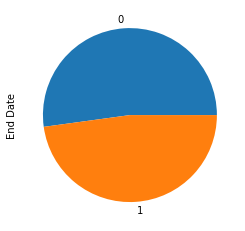

In [57]:
print(target_upsampled.value_counts())
target_upsampled.value_counts().plot(kind='pie')

# 1 = No Churn

# 0 = Churn

1    774
0    563
Name: End Date, dtype: int64
AxesSubplot(0.260833,0.125;0.503333x0.755)


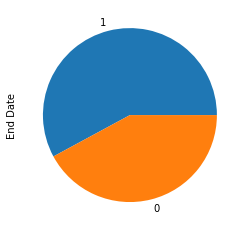

In [58]:
print(target_downsampled.value_counts())
print(target_downsampled.value_counts().plot(kind='pie'))

# 1 = No Churn

# 0 = Churn

# Model Creation

Accuracy Score: 0.8031235210601041
ROC-AUC: 0.8304407859798194


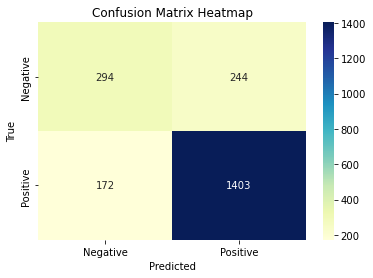

In [59]:
# Normal Logistic Regression

model = LogisticRegression(random_state=12345,solver='liblinear')
model.fit(features_train,target_train)
predicted_valid = model.predict(features_valid)
print('Accuracy Score:',accuracy_score(target_valid,predicted_valid))

probabilities_valid = model.predict_proba(features_valid)

probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('ROC-AUC:', auc_roc)

cm = confusion_matrix(target_valid, predicted_valid)


labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']


sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")


plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.xticks(np.arange(2) + 0.5, ['Negative', 'Positive'])  
plt.yticks(np.arange(2) + 0.5, ['Negative', 'Positive'])  

plt.show()

Accuracy Score: 0.7307146237576905
ROC-AUC: 0.82940107393639


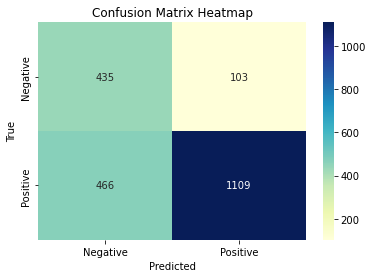

In [60]:
# Upsample Logistic Regression

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled,target_upsampled)
predicted_valid = model.predict(features_valid)
print('Accuracy Score:',accuracy_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('ROC-AUC:', auc_roc) 

cm = confusion_matrix(target_valid, predicted_valid)


labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']


sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")


plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.xticks(np.arange(2) + 0.5, ['Negative', 'Positive'])  # Two tick locations, labeled as Negative and Positive
plt.yticks(np.arange(2) + 0.5, ['Negative', 'Positive'])  # Two tick locations, labeled as Negative and Positive

plt.show()

Accuracy Score: 0.7714150496923805
ROC-AUC: 0.8312798725438131


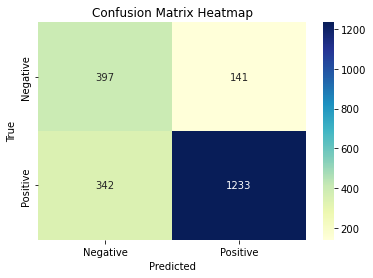

In [61]:
# Downsampled LogisticRegression

model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_downsampled,target_downsampled)
predicted_valid = model.predict(features_valid)
print('Accuracy Score:',accuracy_score(target_valid, predicted_valid))

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)

print('ROC-AUC:', auc_roc) 

cm = confusion_matrix(target_valid, predicted_valid)


labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']


sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu")


plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.xticks(np.arange(2) + 0.5, ['Negative', 'Positive'])  # Two tick locations, labeled as Negative and Positive
plt.yticks(np.arange(2) + 0.5, ['Negative', 'Positive'])  # Two tick locations, labeled as Negative and Positive

plt.show()

Cross-Validation Accuracy Scores: [0.77358491 0.77358491 0.79245283 0.80094787 0.78199052 0.81516588
 0.74881517 0.8436019  0.8056872  0.81042654]
Cross-Validation ROC-AUC Scores: [0.84810127 0.80350445 0.78774027 0.83329353 0.81036542 0.82165605
 0.77329559 0.88770937 0.79087049 0.84731069]


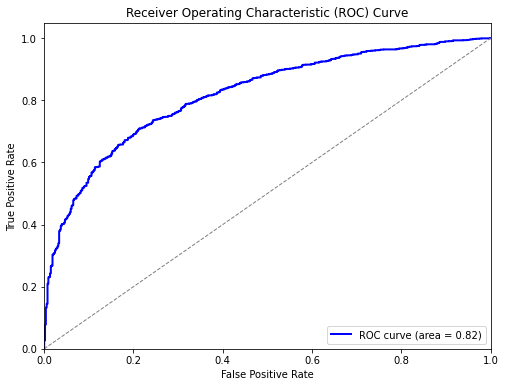

In [65]:
model = GradientBoostingClassifier(loss='log_loss', learning_rate=0.1, n_estimators=150, max_depth=3, min_samples_split=0.03, random_state=12345)

# Cross-Validation
cv_scores_accuracy = cross_val_score(model, features_valid, target_valid, cv=10, scoring='accuracy',error_score='raise')
cv_scores_f1 = cross_val_score(model, features_valid, target_valid, cv=10, scoring='f1')
cv_scores_roc_auc = cross_val_score(model, features_valid, target_valid,cv=10, scoring='roc_auc')

print('Cross-Validation Accuracy Scores:', cv_scores_accuracy)
print('Cross-Validation ROC-AUC Scores:', cv_scores_roc_auc)

# Model Training on Upsampled Data
model.fit(features_train, target_train)

# Predict Probabilities using Cross-Validation on features_valid
predicted_probabilities = cross_val_predict(model, features_valid, target_valid, cv=5, method='predict_proba')

# Calculate ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(target_valid, predicted_probabilities[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [66]:
cat_model = CatBoostClassifier(iterations=200, learning_rate=0.1, depth=6, loss_function='Logloss', random_seed=12345)
cat_model.fit(features_downsampled,target_downsampled)
cat_predicted_valid = cat_model.predict(features_valid)


print('CatBoost Classifier:')
print('Accuracy Score:', accuracy_score(target_valid, cat_predicted_valid))
print()
probabilities_valid_cat = cat_model.predict_proba(features_valid)
probabilities_one_valid_cat = probabilities_valid_cat[:, 1]
auc_roc_cat = roc_auc_score(target_valid, probabilities_one_valid_cat)
print('ROC-AUC:', auc_roc_cat)
print()

xgb_model = xgb.XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=12345)
xgb_model.fit(features_downsampled,target_downsampled)
xgb_predicted_valid = xgb_model.predict(features_valid)


print('\nXGBoost Classifier:')
print('Accuracy Score:', accuracy_score(target_valid, xgb_predicted_valid))


probabilities_valid_xgb = xgb_model.predict_proba(features_valid)
probabilities_one_valid_xgb = probabilities_valid_xgb[:, 1]
auc_roc_xgb = roc_auc_score(target_valid, probabilities_one_valid_xgb)
print('ROC-AUC:', auc_roc_xgb)


lgb_model = lgb.LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=12345)
lgb_model.fit(features_downsampled,target_downsampled)
lgb_predicted_valid = lgb_model.predict(features_valid)


print('\nLightGBM Classifier:')
print('Accuracy Score:', accuracy_score(target_valid, lgb_predicted_valid))

probabilities_valid_lgb = lgb_model.predict_proba(features_valid)
probabilities_one_valid_lgb = probabilities_valid_lgb[:, 1]
auc_roc_lgb = roc_auc_score(target_valid, probabilities_one_valid_lgb)
print('ROC-AUC:', auc_roc_lgb)


0:	learn: 0.6433301	total: 158ms	remaining: 31.5s
1:	learn: 0.6065832	total: 162ms	remaining: 16s
2:	learn: 0.5766705	total: 165ms	remaining: 10.8s
3:	learn: 0.5473433	total: 167ms	remaining: 8.2s
4:	learn: 0.5272888	total: 172ms	remaining: 6.71s
5:	learn: 0.5137728	total: 175ms	remaining: 5.66s
6:	learn: 0.5008339	total: 178ms	remaining: 4.89s
7:	learn: 0.4912472	total: 180ms	remaining: 4.33s
8:	learn: 0.4788850	total: 183ms	remaining: 3.88s
9:	learn: 0.4680437	total: 186ms	remaining: 3.54s
10:	learn: 0.4582656	total: 189ms	remaining: 3.24s
11:	learn: 0.4497178	total: 191ms	remaining: 3s
12:	learn: 0.4435715	total: 194ms	remaining: 2.79s
13:	learn: 0.4380976	total: 196ms	remaining: 2.61s
14:	learn: 0.4327646	total: 199ms	remaining: 2.45s
15:	learn: 0.4271419	total: 201ms	remaining: 2.32s
16:	learn: 0.4223268	total: 204ms	remaining: 2.2s
17:	learn: 0.4169600	total: 207ms	remaining: 2.09s
18:	learn: 0.4123607	total: 209ms	remaining: 1.99s
19:	learn: 0.4083777	total: 212ms	remaining: 1.9

In [67]:
model = RandomForestClassifier(random_state=12345)


param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=10, scoring='roc_auc')

grid_search.fit(features_train,target_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


predicted_valid = best_model.predict(features_valid)
probabilities_one_valid = best_model.predict_proba(features_valid)[:, 1]


print('Best Hyperparameters:', best_params)
print('Accuracy Score:', accuracy_score(target_valid, predicted_valid))
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC:', auc_roc)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
Accuracy Score: 0.795551348793185
ROC-AUC: 0.8269386912137842


# Random Forest Algorithm CV

In [68]:
model = RandomForestClassifier(random_state=12345)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')

grid_search.fit(features_train,target_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


predicted_valid = best_model.predict(features_test)
probabilities_one_valid = best_model.predict_proba(features_test)[:, 1]


print('Best Hyperparameters:', best_params)
print('Accuracy Score:', accuracy_score(target_test, predicted_valid))
auc_roc = roc_auc_score(target_test, probabilities_one_valid)
print('ROC-AUC:', auc_roc)

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}
Accuracy Score: 0.7934705464868701
ROC-AUC: 0.8313595655487804


# Conclusion

The first steps took was to explore all the data in each data set. Missing values, data types, there was no duplicated data, & skewed right data was filled with the median. After that, all 4 dataframes were merged onto the same CustomerID. If the customer did not buy a particular item, the data was filled with "Do not Purchase". Data was explored, and showed the difference between billing, payment methods, & what they bought before they canceled. There was only one addtional metric, and that was the tenure of the canceled user. Data was split 60-20-20, classes were balanced, & the final model was a GridSearch Cross Validation Random Forest Algorithm recieving a .83 AUC-ROC score * about a .8 Accuracy score. 

The difficulties I encountered were how different algorithms are affected by encoding techniques. The notebook shows 2 different techniques. One being labelencoder, which was only used on the target, & the features were onehotencoded. Also, kept obtaining a ROC-AUC score of 84-83. Want to get to 85+, & have yet figured it out, although after hyperparameter tuning, the model was able to get a near .8 accuracy score after raning between 74-76.

First, it was merging the data on one dataframe so all the data can be tested on, & also incorporating both upsampling & downsampling. Different methods provided different answers for model accuracy & AUC-ROC score

Random Forest Algorithm CV

Best Hyperparameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 150}

Accuracy Score: 0.7934705464868701

ROC-AUC: 0.8313595655487804

